In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum scrambling experiment example

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/otoc/otoc_example"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/otoc/otoc_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/otoc/otoc_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/otoc/otoc_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial shows an experiment example from the publication [Information scrambling in computationally complex quantum circuits](https://arxiv.org/abs/2101.08870) (henceforth "OTOC paper"), in particular how to recreate Figure 1.

## Background on quantum scrambling

Quantum scrambling describes how interaction in a quantum system disperses local information into its many degrees of freedom. Analogous to classical chaos, scrambling manifests itself as a [butterfly effect](https://en.wikipedia.org/wiki/Butterfly_effect) wherein a local perturbation is rapidly amplified over time. The perturbation is modeled by a local operator $\hat{O}$ (the *butterfly operator*) acting on a qubit (the *butterfly qubit*). Under a dynamical process $\hat{U} = \hat{U}(t)$, the butterfly operator evolves in the Heisenberg picture as

$$
\hat{O} (t) = \hat{U}^\dagger \hat{O} \hat{U}
$$

Expanding the butterfly operator in a basis

$$
\hat{O} (t) = \sum_{i = 1}^{n_p} w_i B_i 
$$

where $B_i = B^{(1)}_i \otimes \cdots \otimes B^{(n)}_i$ are basis elements and $w_i$ are coefficients, we can describe the two different mechanisms of quantum scrambling as follows:

- *Operator spreading* occurs when basis elements $B_i$ require a higher weight (fewer non-identity terms) on average to describe $\hat{O}(t)$.
- *Operator entanglement* occurs when a larger $n_p$ (summation index) is required to describe $\hat{O}(t)$.

We experimentally evaluate the out-of-time order correlator (OTOC) $C(t)$ between $\hat{O}(t)$ and a *measurement operator* $\hat{M}$ which is a Pauli operator acting on another qubit (the *measurement qubit*)

$$
C(t) := \langle \hat{O} ^\dagger (t) M^\dagger \hat{O} (t) M \rangle
$$

over a collection of quantum circuits with microscopic differences (e.g., in the phases of gates). Operator scrambling is then reflected in the average OTOC value $\bar{C}(t)$ over different circuits:

- $\bar{C}(t) = 1$ when $\hat{O}(t)$ and $\hat{M}$ do not overlap.
- $\bar{C}(t) < 1$ when $\hat{O}(t)$ and $\hat{M}$ overlap.
- $\bar{C}(t) \rightarrow 0$ in the fully scrambled limit where the commutation between $\hat{O}(t)$ and $\hat{M}$ is completely randomized.

Note that if operator entanglement is also present ($n_p \gg 1$), $\bar{C}(t)$ approaches $0$ for all circuits and their fluctuation vanishes as well.

In what follows, we show how to build OTOC circuits, run them and compute $\bar{C}$, then visualize results and detect operator spreading.

## Setup

In [3]:
try:
    import recirq
except ImportError:
    print("Installing ReCirq...")
    !pip install git+https://github.com/quantumlib/recirq --quiet
    print("Installed ReCirq!")

Installing ReCirq...
     |████████████████████████████████| 1.5 MB 8.9 MB/s 
     |████████████████████████████████| 380 kB 34.4 MB/s 
     |████████████████████████████████| 5.8 MB 22.9 MB/s 
     |████████████████████████████████| 33.7 MB 49 kB/s 
     |████████████████████████████████| 1.3 MB 43.8 MB/s 
     |████████████████████████████████| 15.7 MB 75 kB/s 
     |████████████████████████████████| 229 kB 68.5 MB/s 
Installed ReCirq!


In [4]:
import matplotlib.pyplot as plt
import numpy as np

import cirq
import cirq_google as cg
from recirq import otoc

Note: Leave the `project_id` and/or `processor_id` blank to use a noisy simulator.

In [5]:
import os

# The Google Cloud Project id to use.
project_id = '' #@param {type:"string"}


use_noisy_simulator = False
if project_id == '' and 'GOOGLE_CLOUD_PROJECT' not in os.environ:
    print("No project_id provided and environment variable "
          "GOOGLE_CLOUD_PROJECT not set.")
    use_noisy_simulator = True
else: 
    os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

    def authenticate_user():
        """Runs the user through the Colab OAuth process.

        Checks for Google Application Default Credentials and runs interactive login 
        if the notebook is executed in Colab. In case the notebook is executed in Jupyter notebook
        or other IPython runtimes, no interactive login is provided, it is assumed that the 
        `GOOGLE_APPLICATION_CREDENTIALS` env var is set or `gcloud auth application-default login`
        was executed already.

        For more information on using Application Default Credentials see 
        https://cloud.google.com/docs/authentication/production
        """
        in_colab = False
        try:
            from IPython import get_ipython
            in_colab = 'google.colab' in str(get_ipython())
        except: 
            # Notebook is not executed within IPython. Assuming external authentication.
            return 

        if in_colab: 
            from google.colab import auth      
            print("Getting OAuth2 credentials.")
            print("Press enter after entering the verification code.")
            auth.authenticate_user(clear_output=False)
            print("Authentication complete.")
        else: 
            print("Notebook is not executed with Colab, assuming Application Default Credentials are setup.") 

    authenticate_user()
    print("Successful authentication to Google Cloud.")

processor_id = "" #@param {type:"string"}
use_noisy_simulator = use_noisy_simulator or processor_id == "" 
if use_noisy_simulator:
    print("Using a noisy simulator.")
    sampler = cg.PhasedFSimEngineSimulator.create_with_random_gaussian_sqrt_iswap(
        mean=cg.SQRT_ISWAP_INV_PARAMETERS,
        sigma=cg.PhasedFSimCharacterization(
            theta=0.01, zeta=0.10, chi=0.01, gamma=0.10, phi=0.02
        ),
    )
    device = cg.Bristlecone
else:
    sampler = cg.get_engine_sampler(processor_id, gate_set_name="sqrt_iswap")
    device = cg.get_engine_device(processor_id=processor_id)

No project_id provided and environment variable GOOGLE_CLOUD_PROJECT not set.
Using a noisy simulator.


## Build the OTOC circuits

### Picking qubits

First we specify a line of qubits to use. If running on the `cirq_google.Engine`, use the latest calibration report to identify a good line of qubits.

In [6]:
if not use_noisy_simulator:
    calibration = cg.get_engine_calibration(processor_id=processor_id)
    calibration.heatmap(key="two_qubit_sycamore_gate_xeb_average_error_per_cycle").plot();

Note that the ancilla qubit must be adjacent to the first qubit, and the first qubit is treated as the measurement qubit described above.

In [7]:
qubit_indices = [(4, 1), (4, 2), (5, 2), (5, 3), (6, 3), (7, 3), (7, 4), (7, 5)]
ancilla_index = (5, 1)

qubits = [cirq.GridQubit(*idx) for idx in qubit_indices]
ancilla = cirq.GridQubit(*ancilla_index)
num_qubits = len(qubits)

### Qubit interactions and experiment parameters

Now we specify how qubits interact (in other words, the pattern of two-qubit gates). For the 1D chain in this example, only two layers of two-qubit gates (CZ is used here) are needed to enact all interactions.

In [8]:
# Staggered two-qubit interaction pattern.
int_sets = [
    {(qubits[i], qubits[i + 1]) for i in range(0, num_qubits - 1, 2)},
    {(qubits[i], qubits[i + 1]) for i in range(1, num_qubits - 1, 2)},
]

# Use CZ for the two-qubit interaction.
forward_ops = {
    (qubit_indices[i], qubit_indices[i + 1]): cirq.Circuit([cirq.CZ(qubits[i], qubits[i + 1])])
    for i in range(num_qubits - 1)
}

# CZ is self-inverse.
reverse_ops = forward_ops.copy()

Finally, we specify a number of trials to average over when computing $\bar{C}(t)$, and a list of cycles which corresponds to discrete time values $t$ at which to compute $\bar{C}$.

In [9]:
num_trials = 4  # For averaging.
cycles = range(0, 20 + 1, 2)  # Number of circuit cycles.

### Build the circuits

With the specified parameters, we use `recirq.otoc.build_otoc_circuits` to create the set of circuits. First we show an example for a given number of cycles and given butterfly qubit.

In [10]:
# Example number of cycles and butterfly qubit.
cycle = cycles[1]
q_b = qubits[2]

otoc_circuits = otoc.build_otoc_circuits(
    qubits,
    ancilla,
    cycle,
    int_sets,
    forward_ops=forward_ops,
    reverse_ops=reverse_ops,
    butterfly_qubits=q_b,
    cycles_per_echo=2,
    sq_gates=np.random.choice(8, (num_qubits, max(cycles))),
    use_physical_cz=True,
)

The output is an instance of `recirq.otoc.otoc_circuits.OTOCCircuits` which contains lists of circuits with $X$, $Y$, and $Z$ butterfly operators on the butterfly qubit. Additionally, a list of circuits with no butterfly operator (equivalently, with the identity $I$ as the butterfly operator) is included to renormalize results.

In [11]:
print("Ancilla qubit:", ancilla)
print("Measurement qubit:", qubits[0])
print("Butterfly qubit:", q_b)

print("\nExample OTOC circuit:\n")
otoc_circuits.butterfly_Y[0]

Ancilla qubit: (5, 1)
Measurement qubit: (4, 1)
Butterfly qubit: (5, 2)

Example OTOC circuit:



(4, 1): ───Y^0.5────────@───X^0.5────────────@───X^0.5────────────────────────X^-0.5───────────@───X^-0.5───────────@─────────────────────────
                        │                    │                                                 │                    │
(4, 2): ───Y^0.5────────┼───X^-0.5───────────@───PhX(0.75)^0.5────@───────@───PhX(-0.25)^0.5───@───X^0.5────────────┼─────────────────────────
                        │                                         │       │                                         │
(5, 1): ───PhX(0)^0.5───@────────────────────────Y────────────────┼───────┼───Y─────────────────────────────────────@───PhX(0)^0.5───M('z')───
                                                                  │       │
(5, 2): ───Y^0.5────────────X^0.5────────────@───X^0.5────────────@───Y───@───X^-0.5───────────@───X^-0.5─────────────────────────────────────
                                             │                                                 │
(5, 3): ───Y^0.5────────────Y^-0.5───────────@───PhX(0.75)^0.5────@───────@───PhX(-0.25)^0.5───@───Y^0.5──────────────────────────────────────
                                                                  │       │
(6, 3): ───Y^0.5────────────X^-0.5───────────@───PhX(0.75)^0.5────@───────@───PhX(-0.25)^0.5───@───X^0.5──────────────────────────────────────
                                             │                                                 │
(7, 3): ───Y^0.5────────────PhX(-0.25)^0.5───@───PhX(-0.25)^0.5───@───────@───PhX(0.75)^0.5────@───PhX(0.75)^0.5──────────────────────────────
                                                                  │       │
(7, 4): ───Y^0.5────────────PhX(0.75)^0.5────@───Y^-0.5───────────@───────@───Y^0.5────────────@───PhX(-0.25)^0.5─────────────────────────────
                                             │                                                 │
(7, 5): ───Y^0.5────────────PhX(-0.75)^0.5───@───X^-0.5───────────────────────X^0.5────────────@───PhX(0.25)^0.5──────────────────────────────

Note that Pauli $Y$ acts on the chosen butterfly qubit and the measurement is on the ancilla. Compare this circuit to Fig. 1(a) & (b) of the [OTOC paper](https://arxiv.org/abs/2101.08870).

Now we create all OTOC circuits for the experiment, varying the number of cycles and the butterfly qubit.

In [12]:
np.random.seed(0)  # Random seed for OTOC circuits.

circuit_list = []
for i in range(num_trials):
    circuits_i = []

    for cycle in cycles:
        circuits_ic = []
  
        for k, q_b in enumerate(qubits[1:]):
            circs = otoc.build_otoc_circuits(
                qubits,
                ancilla,
                cycle,
                int_sets,
                forward_ops=forward_ops,
                reverse_ops=reverse_ops,
                butterfly_qubits=q_b,
                cycles_per_echo=2,
                sq_gates=np.random.choice(8, (num_qubits, max(cycles))),
                use_physical_cz=True,
            )

            # If q_b is the measurement qubit, add both the normalization 
            # circuits and the circuits with X as the butterfly operator. 
            # Otherwise only add circuits with Y being the butterfly operator.
            if k == 0:
                circuits_ic.extend(circs.butterfly_I)
                circuits_ic.extend(circs.butterfly_X)
            else:
                circuits_ic.extend(circs.butterfly_Y)

        circuits_i.append(circuits_ic)
    circuit_list.append(circuits_i)

The `circuit_list` is a three-dimensional array where the first axis corresponds to the trial, the second axis corresponds to the number of cycles, and the third axis corresponds the butterfly operator / qubit ($Q_b$).

## Run the circuits

Now we run the circuits and process the results.

In [13]:
# Compile to sqrt_iswap.
from tqdm import tqdm

progress = tqdm(total=np.array(circuit_list, dtype=object).size)
for i, circuits_trial in enumerate(circuit_list):
    for j, circuits_cycle in enumerate(circuits_trial):
        for k, circuit_otoc in enumerate(circuits_cycle):
            circuit_list[i][j][k] = cg.optimized_for_sycamore(circuit_otoc, optimizer_type="sqrt_iswap")
            progress.update()

100%|██████████| 1408/1408 [14:50<00:00,  1.46s/it]

In [14]:
results = []
for i, circuits_i in enumerate(circuit_list):
    results_i = np.zeros((num_qubits, len(cycles)))

    for c, circuits_ic in enumerate(circuits_i):
        print("\r", f"On trial {i + 1} / {num_trials}, cycle {c + 1} / {len(cycles)}.", end="")

        job = sampler.run_batch(
            programs=circuits_ic, 
            params_list=[{} for _ in range(len(circuits_ic))], 
            repetitions=int(2_000 + 10_000 * (c / max(cycles)) ** 3),
        )

        # Compute ⟨σ_y⟩ (or normalization ⟨I⟩).
        for d in range(num_qubits):
            p =  np.mean(job[4 * d    ][0].measurements["z"])
            p -= np.mean(job[4 * d + 1][0].measurements["z"])
            p -= np.mean(job[4 * d + 2][0].measurements["z"])
            p += np.mean(job[4 * d + 3][0].measurements["z"])
            results_i[d, c] = 0.5 * p
    results.append(results_i)

 On trial 4 / 4, cycle 11 / 11.

## Plot the results

First we plot the normalization factor and $\langle \sigma_y \rangle$ on each butterfly qubit.

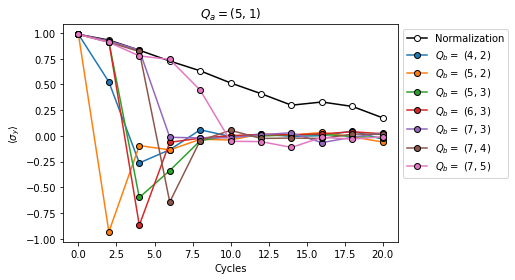

In [15]:
# Average the data for the `num_trials` random circuits.
results_ave = np.mean(results, axis=0)

# Plot the result with no butterfly operator.
plt.plot(cycles, results_ave[0, :], "o-", color="black", mec="black", mfc="white", label="Normalization")

# Plot results for each butterfly qubit.
for i in range(1, num_qubits):
    plt.plot(cycles, results_ave[i, :], "o-", mec="black", label="$Q_b =$ {}".format(qubits[i]))

plt.title(f"$Q_a = {ancilla}$")
plt.xlabel("Cycles")
plt.ylabel(r"$\langle \sigma_y \rangle$")
plt.legend(bbox_to_anchor=(1, 1));

Compare this plot to Fig. 1(c) (left panel) of the [OTOC paper](https://arxiv.org/abs/2101.08870). The values of $\langle \sigma_y \rangle$ decay below 1 before $\hat{O}$ and $\hat{M}$ overlap due to noise. The curve labeled "normalization" contains no butterfly operator and its decay is solely due to noise. By renormalizing, we can analyze the effects due to quantum scrambling.

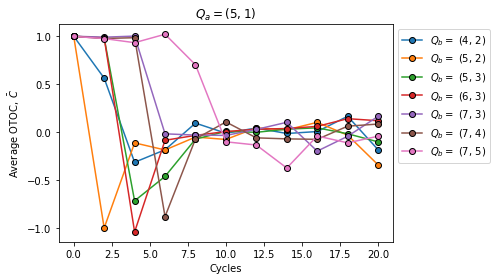

In [16]:
for i in range(1, num_qubits):
    plt.plot(cycles, results_ave[i, :] / results_ave[0, :], "o-", mec="black", label="$Q_b =$ {}".format(qubits[i]))

plt.title(f"$Q_a = {ancilla}$")
plt.xlabel("Cycles")
plt.ylabel(r"Average OTOC, $\bar{C}$")
plt.legend(bbox_to_anchor=(1, 1));

Note that for each location of $Q_b$, $\bar{C}$ retains values near 1 before sufficient circuit cycles have occured to allow an overlap between $\hat{O}$ and $\hat{M}$. Beyond these cycles, $\bar{C}$ converges to $0$, indicating that $\hat{O}$ and $\hat{M}$ have overlapped and no longer commute. These observations show behavior consistent with operator spreading as described at the start of this tutorial. Compare this plot to Fig. 1(c) (right panel) of the [OTOC paper](https://arxiv.org/abs/2101.08870).